## Image Classification with Pytorch

This notebook is my first classification work and it could be look coarse but i think it will be helpful to pytorch real starter.

### there are 8 processes while doing this job.

1. import Library
2. hyper parameter setting
3. set seed and random value 
4. data load
5. make our model
6. set our loss function and optimizer
7. train
8. check our model performance or using test datasets in trained model


### 1. Import Library

In [1]:
#about torch...
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

#using numpy
import numpy as np

#for data load or save
import pandas as pd

#visualize some datasets
import matplotlib.pyplot as plt

#check our work directory
import os

#to unzip datasets
import zipfile

### 2. Hyper parameters Setting

In [2]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 10 # How much to train a model

3. Set seed and Random Value

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)  # 为所有的GPU设置种子

### 4. Load train,  test data

In this competition, we can't use datasets with only pandas
we should to unzip datasets. and we must check our working directory before unzipping

check a directory

In [12]:
os.listdir('../input/dogs-vs-cats-redux-kernels-edition')

['test.zip', 'train.zip']

#### make a directory for our datasets after unzipping

In [13]:
os.makedirs('../data', exist_ok=True)

In [14]:
base_dir = '../input/dogs-vs-cats-redux-kernels-edition'
train_dir = '../data/train'
test_dir = '../data/test'

In [15]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [16]:
os.listdir(train_dir)[:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

In [17]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [18]:
len(train_list)

25000

#### check our datasets

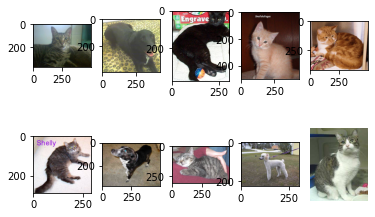

In [19]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [22]:
train_list[0].split('\\')[-1].split('.')[0]

'cat'

In [23]:
int(test_list[0].split('\\')[-1].split('.')[0])

1

In [24]:
print(len(train_list), len(test_list))

25000 12500


In [26]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

### Image Augumentation
- we have to do this job before making our model. cuz it will prevent overfitting Possibility

In [27]:
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])


### Load datasets
- this code is for load our image sets. you can find this code easily in pytorch.org , main page

In [58]:
class dataset(torch.utils.data.Dataset):
    #가져와서 처리
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label
        

#### use torchvision.datasets

In [59]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [60]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [61]:
print(len(train_data), len(train_loader))

20000 200


In [62]:
print(len(val_data), len(val_loader))

5000 50


In [63]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

### build Model
- 3 Convolution layer and 2 fully connected layer
- batchNormalization for limit overfitting

In [64]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [65]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

### set Loss function and optimizer

In [67]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

### Train our Network

In [69]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

KeyboardInterrupt: 

In [70]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

KeyboardInterrupt: 

- In this Problem, we used softmax except sigmoid. 
- why? isn't it binary classification?
- before i read overview, i didn't recognize that. read overview about this competition First!!

In [71]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs

[('2', 0.5324298739433289),
 ('4', 0.9866887927055359),
 ('6', 0.5321677327156067),
 ('7', 0.3488987684249878),
 ('8', 0.3520655632019043),
 ('12', 0.3932136297225952),
 ('13', 0.3942878842353821),
 ('17', 0.4664345681667328),
 ('18', 0.7276716232299805),
 ('20', 0.3954729437828064),
 ('22', 0.3460143506526947),
 ('23', 0.37865912914276123),
 ('25', 0.5131941437721252),
 ('28', 0.36406272649765015),
 ('32', 0.4686150550842285),
 ('34', 0.3021405041217804),
 ('35', 0.43030816316604614),
 ('38', 0.3413101136684418),
 ('41', 0.326427698135376),
 ('42', 0.8362982273101807),
 ('43', 0.4332748055458069),
 ('49', 0.3626834750175476),
 ('50', 0.3177729845046997),
 ('52', 0.38242751359939575),
 ('54', 0.2736474871635437),
 ('57', 0.7319529056549072),
 ('58', 0.348388135433197),
 ('60', 0.42850804328918457),
 ('62', 0.4341326057910919),
 ('64', 0.2639772891998291),
 ('65', 0.47108811140060425),
 ('66', 0.3076075613498688),
 ('67', 0.5007013082504272),
 ('69', 0.5024077892303467),
 ('70', 0.36979

In [72]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

In [73]:
submission = pd.DataFrame({'id':idx,'label':prob})

In [74]:
submission

,id,label
0,2,0.532430
1,4,0.986689
2,6,0.532168
3,7,0.348899
4,8,0.352066
...,...,...
4595,12485,0.401891
4596,12486,0.918838
4597,12493,0.392251
4598,12494,0.452339


In [75]:
submission.to_csv('result.csv',index=False)

### check our model performance and visualize some data!

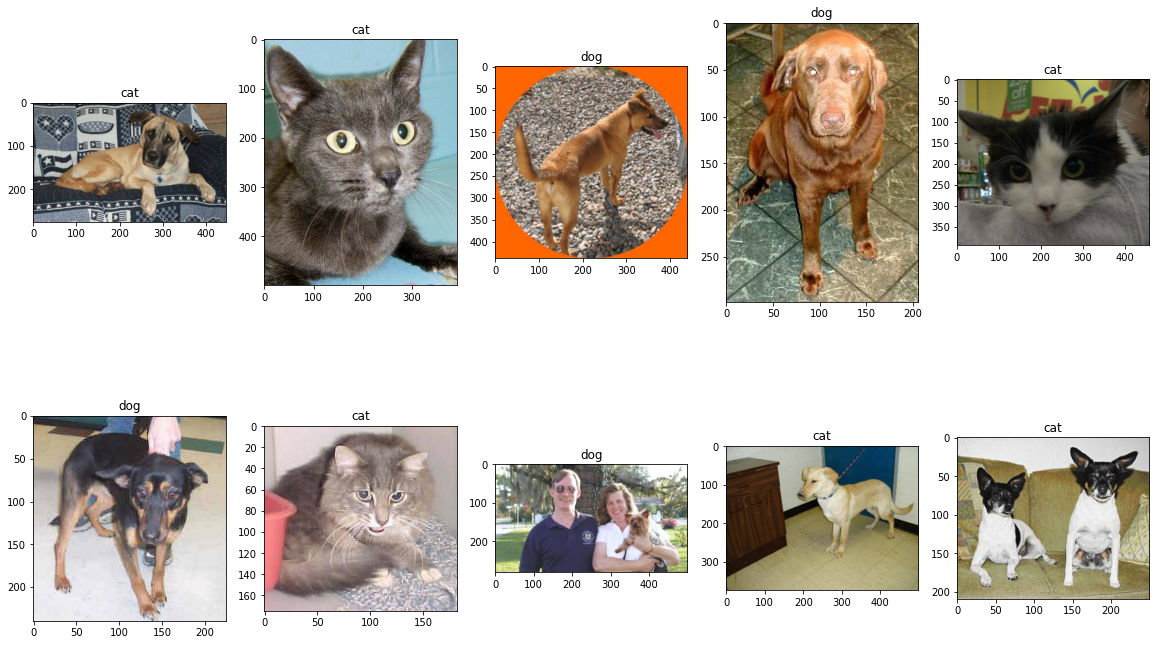

In [76]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)